### 텐서플로를 활용한 구글넷 구현

In [1]:
import tensorflow as tf
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, Activation, Input, AveragePooling2D, concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

170498071/170498071 [==============================] - 2s 0us/step


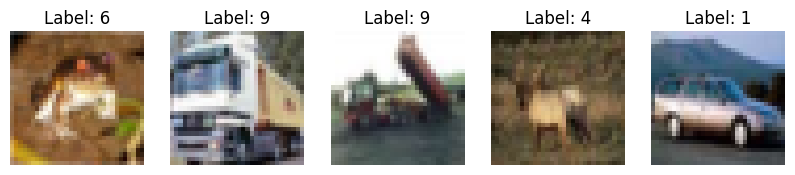

In [2]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
num_classes = 10

plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_x[i])
    plt.title(f"Label: {train_y[i][0]}")
    plt.axis('off')
plt.show()

In [3]:
print(f"스케일링 전 픽셀의 최대 값과 최소 값 : {train_x.min()} ~ {train_x.max()}")
train_x = train_x/255.
test_x = test_x/255.
print(f"스케일링 후 픽셀의 최대 값과 최소 값 : {train_x.min()} ~ {train_x.max()}")

스케일링 전 픽셀의 최대 값과 최소 값 : 0 ~ 255
스케일링 후 픽셀의 최대 값과 최소 값 : 0.0 ~ 1.0


In [4]:
image_size = (32, 32)
batch_size = 64
weight_decay = 5e-4
learning_rate = 1e-2
epochs = 40

In [5]:
def conv2d_bn_relu(x, filters, kernel_size, weight_decay=.0, strides=1):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same',
               kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = BatchNormalization(scale=False, axis=3)(x)
    x = Activation('relu')(x)
    return x

In [6]:
def inception_module(x, filters_num_array, weight_decay=.0):
    (br0_filters, br1_filters, br2_filters, br3_filters) = filters_num_array
    br0 = conv2d_bn_relu(x, filters=br0_filters, kernel_size=1, weight_decay=weight_decay)
    br1 = conv2d_bn_relu(x, filters=br1_filters[0], kernel_size=1, weight_decay=weight_decay)
    br1 = conv2d_bn_relu(br1, filters=br1_filters[1], kernel_size=3, weight_decay=weight_decay)
    br2 = conv2d_bn_relu(x, filters=br2_filters[0], kernel_size=1, weight_decay=weight_decay)
    br2 = conv2d_bn_relu(br2, filters=br2_filters[1], kernel_size=5)
    br3 = MaxPool2D(pool_size=3, strides=(1, 1), padding='same')(x)
    br3 = conv2d_bn_relu(br3, filters=br3_filters, kernel_size=1, weight_decay=weight_decay)
    x = concatenate([br0, br1, br2, br3], axis=3)
    return x

In [7]:
def googlenet(input_shape, classes, weight_decay=.0):
    input = Input(shape=input_shape)
    x = input
    x = conv2d_bn_relu(x, filters=64, kernel_size=1, weight_decay=weight_decay)
    x = conv2d_bn_relu(x, filters=192, kernel_size=3, weight_decay=weight_decay)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    x = inception_module(x, (64, (96, 128), (16, 32), 32), weight_decay=weight_decay)
    x = inception_module(x, (128, (128, 192), (32, 96), 64), weight_decay=weight_decay)
    x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)
    x = inception_module(x, (192, (96, 208), (16, 48), 64), weight_decay=weight_decay)
    x = inception_module(x, (160, (112, 224), (24, 64), 64), weight_decay=weight_decay)
    x = inception_module(x, (128, (128, 256), (24, 64), 64), weight_decay=weight_decay)
    x = inception_module(x, (112, (144, 288), (32, 64), 64), weight_decay=weight_decay)
    x = inception_module(x, (256, (160, 320), (32, 128), 128), weight_decay=weight_decay)
    x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)
    x = inception_module(x, (256, (160, 320), (32, 128), 128), weight_decay=weight_decay)
    x = inception_module(x, (384, (192, 384), (48, 128), 128), weight_decay=weight_decay)
    x = AveragePooling2D(pool_size=4, strides=1, padding='valid')(x)
    x = Flatten(name='flatten')(x)
    output = Dense(classes, activation='softmax')(x)
    model = Model(input, output)
    return model

In [8]:
googlenet = googlenet(input_shape=(image_size[0], image_size[1], 3),
                      classes=num_classes,
                      weight_decay=weight_decay)

In [9]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
googlenet.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [10]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=4, min_lr=1e-7, verbose=1)

In [11]:
history = googlenet.fit(x=train_x,
                        y=train_y,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=0.2,
                        callbacks = [reduce_lr])

Epoch 1/40
625/625 [==============================] - 73s 82ms/step - loss: 5.1047 - accuracy: 0.5006 - val_loss: 4.9715 - val_accuracy: 0.4927 - lr: 0.0100
Epoch 2/40
625/625 [==============================] - 49s 78ms/step - loss: 4.2458 - accuracy: 0.6733 - val_loss: 4.1016 - val_accuracy: 0.6627 - lr: 0.0100
Epoch 3/40
625/625 [==============================] - 52s 83ms/step - loss: 3.6859 - accuracy: 0.7496 - val_loss: 3.7600 - val_accuracy: 0.6801 - lr: 0.0100
Epoch 4/40
625/625 [==============================] - 50s 80ms/step - loss: 3.2202 - accuracy: 0.8051 - val_loss: 3.2985 - val_accuracy: 0.7372 - lr: 0.0100
Epoch 5/40
625/625 [==============================] - 52s 83ms/step - loss: 2.8436 - accuracy: 0.8437 - val_loss: 3.0290 - val_accuracy: 0.7484 - lr: 0.0100
Epoch 6/40
625/625 [==============================] - 50s 80ms/step - loss: 2.5353 - accuracy: 0.8668 - val_loss: 2.8648 - val_accuracy: 0.7478 - lr: 0.0100
Epoch 7/40
625/625 [==============================] - 50s 

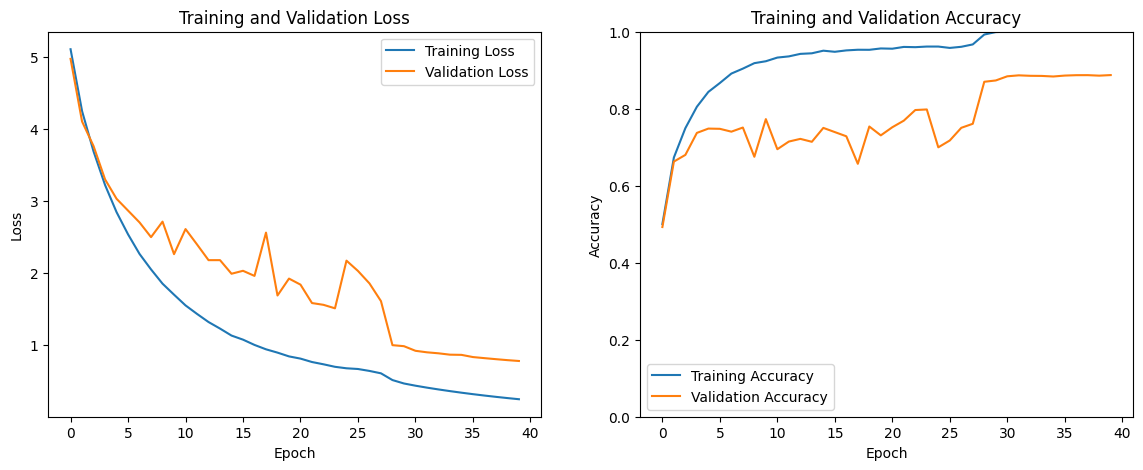

In [12]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

In [13]:
googlenet.evaluate(test_x, test_y)

313/313 [==============================] - 6s 15ms/step - loss: 0.7902 - accuracy: 0.8848


[0.7901834845542908, 0.8848000168800354]